## Problem 4.1: Analysis of FRAP data

In this problem, we aim to extract the normalized fluorescence over time of a spot that has been photobleached. In this dataset, we have 8 TIFF stacks of images, each with 149 frames. The interpixel distance is given to be 0.138 µm, the size of the FRAP spot is 40 by 40 pixels, and each frame is taken 0.188 s apart.

Attribution: Maddie worked on this problem. 

In [1]:
import glob
import os

import numpy as np
import pandas as pd

# Image processing tools
import skimage
import skimage.io

import bebi103

import altair as alt
import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

Let's start by looking at the first TIFF stack.

In [2]:
# Load in first TIFF stack
fname = '../data/goehring_FRAP_data/PH_138_A.tif'
ic = skimage.io.ImageCollection(fname, conserve_memory=False)[0]

# How long is it?
print('There are {0:d} frames.'.format(len(ic)))

There are 149 frames.


We are given that the interpixel distance is 0.138 µm, so let's set it as variable here for plotting later.

In [3]:
ip = 0.138 # µm

We want to segment the bleached area using the first postbleach frame, frame 21. Let's look at the frames right before and right after the photobleaching event, frames 20 and 21.

In [4]:
def show_two_ims(im_1, im_2, titles=[None, None], interpixel_distances=[0.13, 0.13],
                 color_mapper=None):
    """Convenient function for showing two images side by side."""
    p_1 = bebi103.viz.imshow(im_1,
                             plot_height=300,
                             title=titles[0],
                             color_mapper=color_mapper,
                             interpixel_distance=interpixel_distances[0],
                             length_units='µm')
    p_2 = bebi103.viz.imshow(im_2,
                             plot_height=300,
                             title=titles[1],
                             color_mapper=color_mapper,
                             interpixel_distance=interpixel_distances[0],
                             length_units='µm')
    p_2.x_range = p_1.x_range
    p_2.y_range = p_1.y_range
    
    return bokeh.layouts.gridplot([p_1, p_2], ncols=2)

In [5]:
bokeh.io.show(show_two_ims(ic[19], ic[20], titles=['Frame 20', 'Frame 21'], interpixel_distances=[ip, ip]))

The edges of the bleached square are fuzzy due to diffusion. Given from the README that the box should be 40x40 pixels, we can take a 40x40 square over the image and find the square with the lowest intensity. That box will be our bleached spot. 

To find this box, let's write two functions. One will return a convenient array for slicing a region of interest from the image given the center coordinates, and the other will find the photobleached spot by looking for the square with the lowest intensity.

In [6]:
def get_box_given_center(x, y, length):
    '''Given the x and y center coordinates, return an index
    tuple defining a box of edge length length * 2.'''
    left = x - length
    right = x + length
    bottom = y + length
    top = y - length
        
    return np.s_[int(top):int(bottom), int(left):int(right)]

def find_roi(ic, frame=20, length=20):
    '''Given an image stack, take one frame and returns the center 
    coordinates of the darkest square area, given an edge length
    defining that square.'''
    
    # Set the frame of the image stack to another variable for convenience
    im = np.copy(ic[frame])
    
    # Get the dimensions of the image
    x_dim, y_dim = im.shape
    
    # Set initial values for center of bleached spot
    x_center = length
    y_center = length
    
    # Set a high initial value for the lowest intensity of our ROI
    lowest_int = 10**10
    
    # Iterate through all the pixels in the image where the box would fit
    for x, y in [(x,y) for x in np.arange(length, x_dim - length) 
                       for y in np.arange(length, y_dim - length)]:

        # Get coordinates of the box
        roi = get_box_given_center(x, y, length)
        
        # Calculate total intensity of square
        lowest_int_temp = im[roi].sum()

        # Keep track of where box with lower intensity is found
        if lowest_int_temp < lowest_int:
            x_center = x
            y_center = y
            lowest_int = lowest_int_temp
            
    return x_center, y_center

Now let's test our function and see if it returns a box with pretty low intensity. We can plot the original and ROI next to each other.

FIGURE OUT HOW TO DRAW A BOX

In [7]:
x_center, y_center = find_roi(ic)
roi = get_box_given_center(x_center, y_center, 20)

bokeh.io.show(show_two_ims(ic[20], ic[20][roi], titles=['original', 'ROI']))

Now that we have our ROI, we can plot at the total intensity over time of that box. First, let's make a array for time for our x-axis, since we know from the README that each frame is captured every 0.188 s.

In [8]:
# Set up an array for time
t = np.linspace(0, len(ic) * 0.188, len(ic))

Now let's calculate total intensity over time and plot it.

In [9]:
# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(ic))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi].sum() 
    
p = bokeh.plotting.figure(plot_width=500,
                          plot_height=300,
                          x_axis_label='time (s)', 
                          y_axis_label='total intensity')

p.line(t, total_int, line_width=2, line_join='bevel')

bokeh.io.show(p)

This looks like what we expect. After photobleaching, the intensity of the box drops dramatically but recovers over time. Now let's normalize the total intensity. To do this, we can look at the first 19 frames, before photobleaching, and compute the mean total intensity of the bleached area before it is bleached. We want to look at multiple frames as there is noise over time, and the intensity of the ROI will change over time. 

In [10]:
def compute_normalization_value(ic, roi, n_frames):
    '''Takes the first n frames in the image stack to compute
    the average intensity of an ROI over all the frames.'''
    # Set up NumPy array to store total pixel intensity
    total_int = np.empty(len(ic[:n_frames]))
    
    # Sum intensities in first n frames in ROI
    for i, im in enumerate(ic[:n_frames]):
        total_int[i] = im[roi].sum()

    # Return the mean intensity of the ROI
    return np.mean(total_int)

Now to compute the normalized intensity, we just need to divide the intensity we obtained before by the normalization value.

In [11]:
def compute_normalized_intensity(ic, roi, int_0):  
    '''Takes the an image stack, a normalization factor, and an
    ROI to compute the normalized intensity over time for
    all frames. Returns the normalized intensity for each frame.'''
    # Set up NumPy array to store total pixel intensity
    total_int = np.empty(len(ic))
    
    # Set up Numpy array to store time in image stack
    t = np.linspace(0, len(ic) * 0.188, len(ic))

    # Look through and compute total intensity in the ROI
    for i, im in enumerate(ic):
        total_int[i] = im[roi].sum() / int_0
    
    return total_int

Let's plot the normalized intensity. 

In [12]:
int_0 = compute_normalization_value(ic, roi, 19)
total_int = compute_normalized_intensity(ic, roi, int_0)

p = bokeh.plotting.figure(plot_width=500,
                          plot_height=300,
                          x_axis_label='time (s)', 
                          y_axis_label='normalized total intensity')

p.line(t, total_int, line_width=2, line_join='bevel')

bokeh.io.show(p)

We see that the value of the intensity still occasionally goes above 1. This is because of noise in the detector, and potentially another way of calculating the normalization factor could be to find the frame with the highest intensity before photobleaching, and divide by that intensity. 

We also notice that the intensity of the ROI does not completely go to zero. This is also presumably due to noise or incomplete photobleaching.

Let's write another function that will get the max intensity of the ROI before photobleaching.

In [13]:
def compute_normalization(ic, roi, n_frames):
    '''Takes the first n frames in the image stack to compute
    the average intensity of an ROI over all the frames.'''
    # Set up NumPy array to store total pixel intensity
    total_int = np.empty(len(ic[:n_frames]))
    
    # Sum intensities in first n frames in ROI
    for i, im in enumerate(ic[:n_frames]):
        total_int[i] = im[roi].sum()

    # Return the max intensity of the ROI
    return np.max(total_int)

Now we can recalculate and replot the total intensity over time.

In [14]:
int_0 = compute_normalization(ic, roi, 19)
total_int = compute_normalized_intensity(ic, roi, int_0)

p = bokeh.plotting.figure(plot_width=500,
                          plot_height=300,
                          x_axis_label='time (s)', 
                          y_axis_label='normalized total intensity')

p.line(t, total_int, line_width=2, line_join='bevel')

bokeh.io.show(p)

The max normalized intensity is now 1!

Now we can use our functions to compute the normalized intensity over time for all image stacks in the data directory.

In [15]:
# The directory containing data
data_dir = '../data/goehring_FRAP_data/'

# Glob string for images
im_glob = os.path.join(data_dir, '*.tif')

# Get list of files in directory
im_list = sorted(glob.glob(im_glob))

# Let's look at the entries
im_list

['../data/goehring_FRAP_data/PH_138_A.tif',
 '../data/goehring_FRAP_data/PH_138_B.tif',
 '../data/goehring_FRAP_data/PH_138_C.tif',
 '../data/goehring_FRAP_data/PH_138_D.tif',
 '../data/goehring_FRAP_data/PH_138_E.tif',
 '../data/goehring_FRAP_data/PH_138_F.tif',
 '../data/goehring_FRAP_data/PH_138_G.tif',
 '../data/goehring_FRAP_data/PH_138_H.tif']

In [16]:
# Initialize variables
n_frames = 19
length = 20

# Initialize dataframe to store information
df = pd.DataFrame()

for i, fname in enumerate(im_list):
    # Extract image stack
    ic = skimage.io.ImageCollection(fname, conserve_memory=False)[0]
    
    # Find ROI
    x_center, y_center = find_roi(ic)
    roi = get_box_given_center(x_center, y_center, length)
    
    # Compute normalized total intensity
    int_0 = compute_normalization(ic, roi, n_frames)
    total_int = compute_normalized_intensity(ic, roi, int_0)
    
    # Store information in a dataframe
    df_temp = pd.DataFrame(total_int, columns={"total_intensity"})
    df_temp['time'] = t
    df_temp['stack'] = i
    
    df = pd.concat([df, df_temp])
    
# Reset the index so that the indices are all in sequential order
df = df.reset_index(drop=True)

# Take a look
df.head()

,total_intensity,time,stack
0,0.996295,0.000000,0
1,0.971070,0.189270,0
2,0.984476,0.378541,0
3,0.997851,0.567811,0
4,0.974924,0.757081,0


Let's save our dataframe in a csv file for later use.

In [17]:
df.to_csv('normalized_intensities.csv')

We can plot the normalized intensity over time for each image stack.

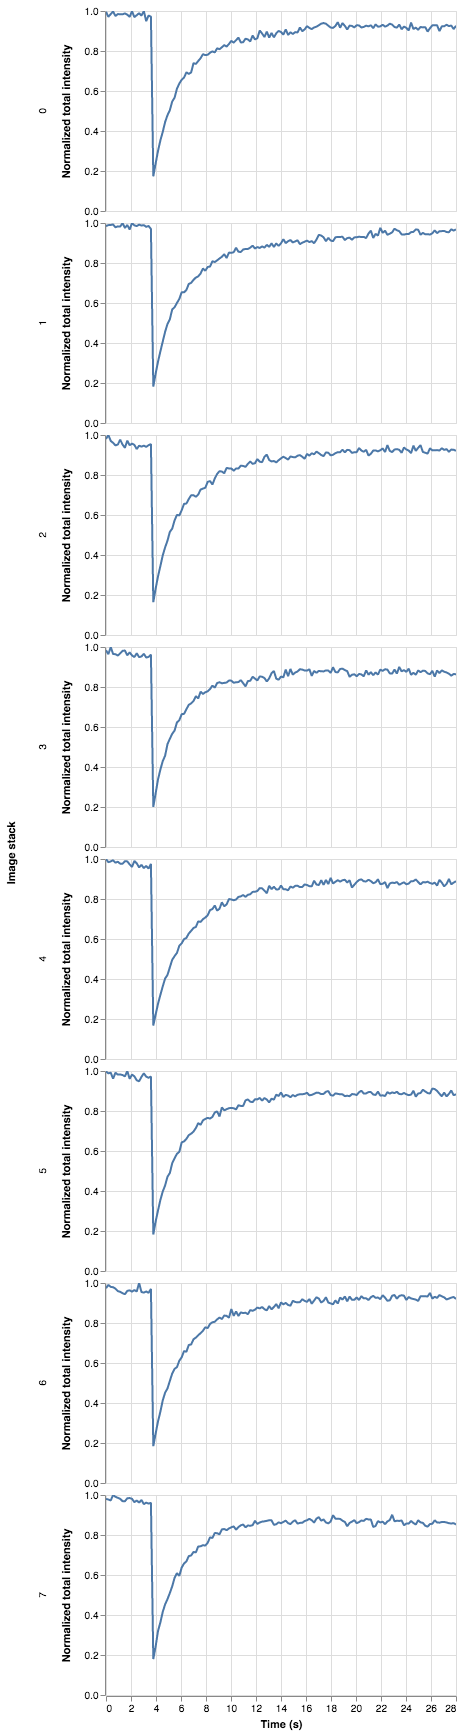

In [18]:
alt.Chart(df,
          height=200,
          width=350
    ).mark_line(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('time:Q', title='Time (s)', scale=alt.Scale(domain=[0, t[-1]], nice=False)),
        y=alt.Y('total_intensity:Q', title='Normalized total intensity'),
        row=alt.Row('stack:Q', title='Image stack'),
        tooltip=['time', 'total_intensity']
    ).interactive()

We can now visualize the traces of normalized fluorescence of the photobleached spot spot versus time from each of the experimental repeats. Each photobleached spot drops to approximately 0.2 of its original value after FRAP is applied, and most recover fairly quickly, reaching around 0.9 of their original intensities by the end of the experiment. 

In [19]:
%load_ext watermark

In [20]:
%watermark -v -p numpy,pandas,scipy,skimage,bokeh,bebi103,jupyterlab

CPython 3.7.0
IPython 7.0.1

numpy 1.15.2
pandas 0.23.4
scipy 1.1.0
skimage 0.14.0
bokeh 0.13.0
bebi103 0.0.28
jupyterlab 0.35.0
